In [2]:
import numpy as np
import scipy.io as scio
from sklearn.decomposition import PCA
import pickle
from math_plds import *
import matplotlib.pyplot as plt
import copy
np.set_printoptions(precision=3)

In [3]:
nld = 4
nts = 20000
nn = 300
nsd = 4
data = scio.loadmat('../data/compiled_dF033016.mat')
frameHz = data['FrameRateHz'][0, 0]  # frames per seconds
y = data['behavdF'].T
onsetframe = data['onsetFrame'].T[0]
onsettime = np.array(data['onsetFrame'].T[0]) / frameHz

resptime = data['resptime'].T[0]
correct = data['correct'][0]

offsettime = onsettime + resptime + 2.75 + (4.85 - 2.75) * (1 - correct)
offsetframe = (offsettime * frameHz).astype(np.int32)

orientation = np.array(data['orient'][0], np.int8)
location = np.array((data['location'][0] + 1) // 2, np.int8)

u = np.zeros((y.shape[0], nsd))
for onf, off, ori, loc in zip(onsetframe, offsetframe, orientation, location):
    for frame in np.arange(onf, off, dtype=np.int32):
        u[frame] = np.array([ori*loc, (1-ori)*loc, ori*(1-loc), (1-ori)*(1-loc)])

stimuli = 1 * (1 - orientation) * location + 2 * orientation * (1 - location) + 3 * (1 - orientation) * (1 - location)

stimulicross = stimuli[np.where(offsetframe > y.shape[0] - nts)[0][0]:]
crossoffsetframe = offsetframe[:len(stimulicross)]
crossonsetframe = (onsetframe[:len(stimulicross)]).astype(np.int32)
# onsetframe = onsetframe.astype(np.int)
yvec = y[:nts*nn]
uvec = u[:nts*nsd]




In [4]:
inf = pickle.load(open('../outputs/pldsrun_2018-4-6-19-2_nld=6.pldsop', 'rb'))
mu = inf['x'][-1].reshape(-1, 6)

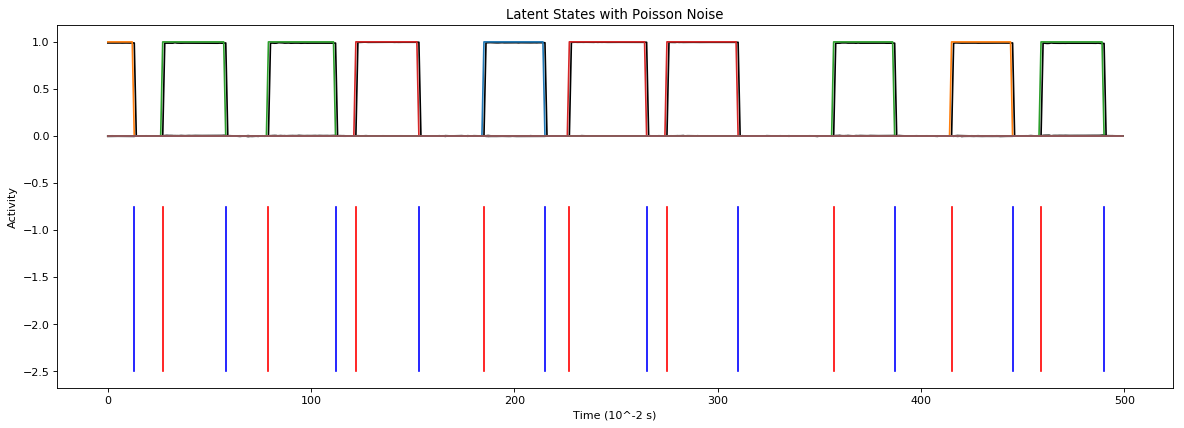

In [5]:
plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(mu[2000:2500], 'k')
plt.plot([inf['B'][-1] @ uv for uv in uvec[2000:2500]])
# plt.plot(u[1500:2000], 'k')
# for off, on in zip(offsetframe, onsetframe):
#     if 2000 < on < 2500:
#         plt.plot([on-2000, on-2000], [-.75, -2.5], 'r')
#     if 2000 < off < 2500:
#         plt.plot([off-2000, off-2000], [-.75, -2.5], 'b')
# plt.title('Latent States with Poisson Noise')
plt.xlabel('Time (10^-2 s)')
plt.ylabel('Activity')
# plt.legend((l1), ('fit'))
plt.show()

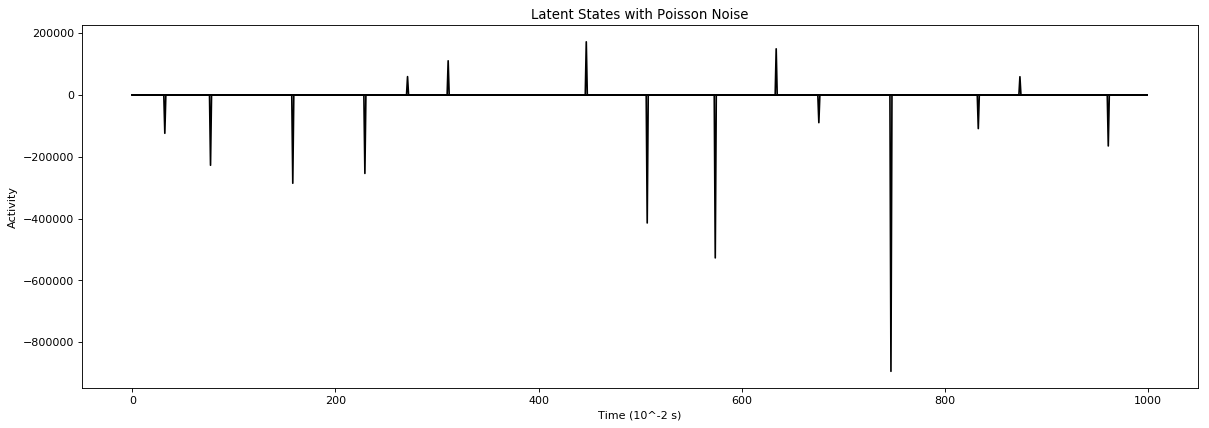

In [6]:
plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
sl = slice(500,1500)
plt.plot([(inf['B'][-1] @ ui) / (inf['A'][-1] @ mui) for ui, mui in zip(uvec[sl], mu[sl])], 'k')
# plt.plot([inf['B'][-1] @ ui for ui in uvec[2000:2500]])
# plt.plot(u[1500:2000], 'k')
# for off, on in zip(offsetframe, onsetframe):
#     if 2000 < on < 2500:
#         plt.plot([on-2000, on-2000], [.75, 2.5], 'r')
#     if 2000 < off < 2500:
#         plt.plot([off-2000, off-2000], [.75, 2.5], 'b')
plt.title('Latent States with Poisson Noise')
plt.xlabel('Time (10^-2 s)')
plt.ylabel('Activity')
# plt.legend((l1), ('fit'))
plt.show()

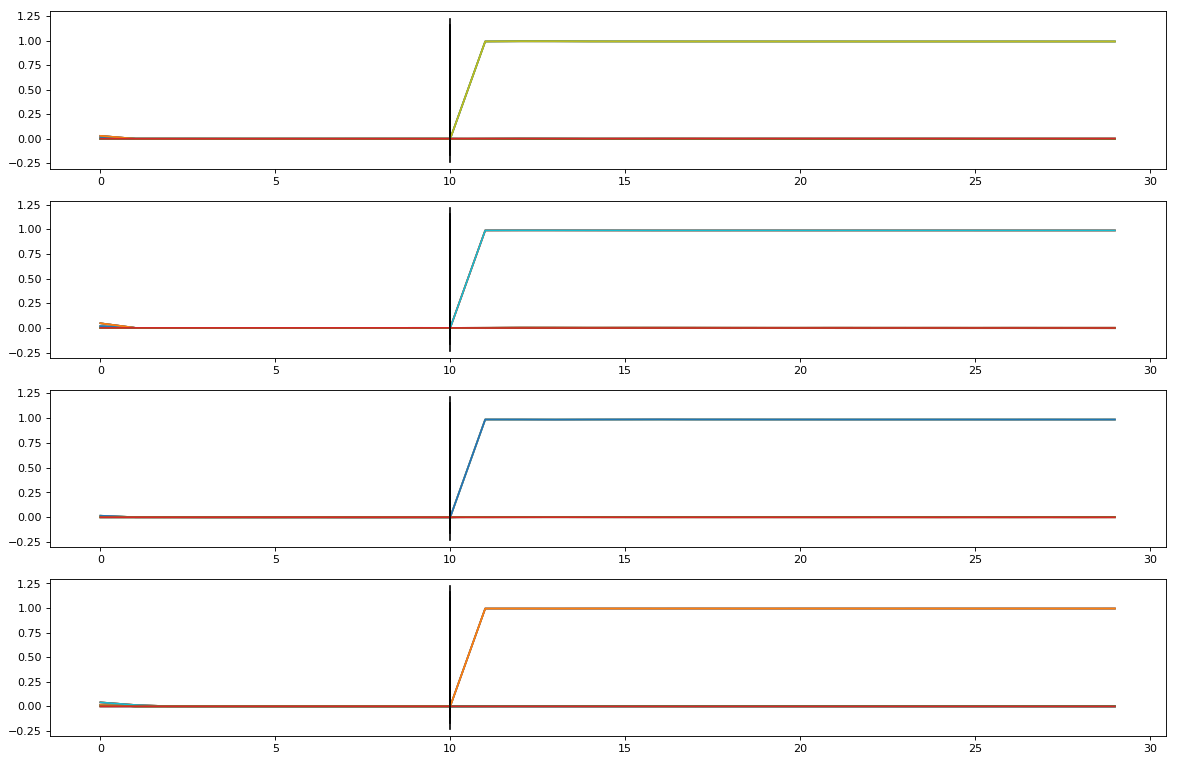

In [7]:
stimgroups = {str(i):[] for i in range(nsd)}
for stim, off, on in zip(stimuli, crossoffsetframe, crossonsetframe):
    stimgroups[str(stim)].append(mu[on - 10: on + 20])
stimgroups = {str(i):np.mean(stimgroups[str(i)], axis=0) for i in range(nsd)}
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
for j in range(nsd):
    plt.subplot(nsd, 1, j+1)
    for i in range(nld):
        plt.plot(stimgroups[str(j)])
        ybounds = plt.ylim()
        plt.plot([10, 10], [ybounds[0], ybounds[1]], 'k-')
plt.show()

/home/bkorkor/miniconda3/envs/plds/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


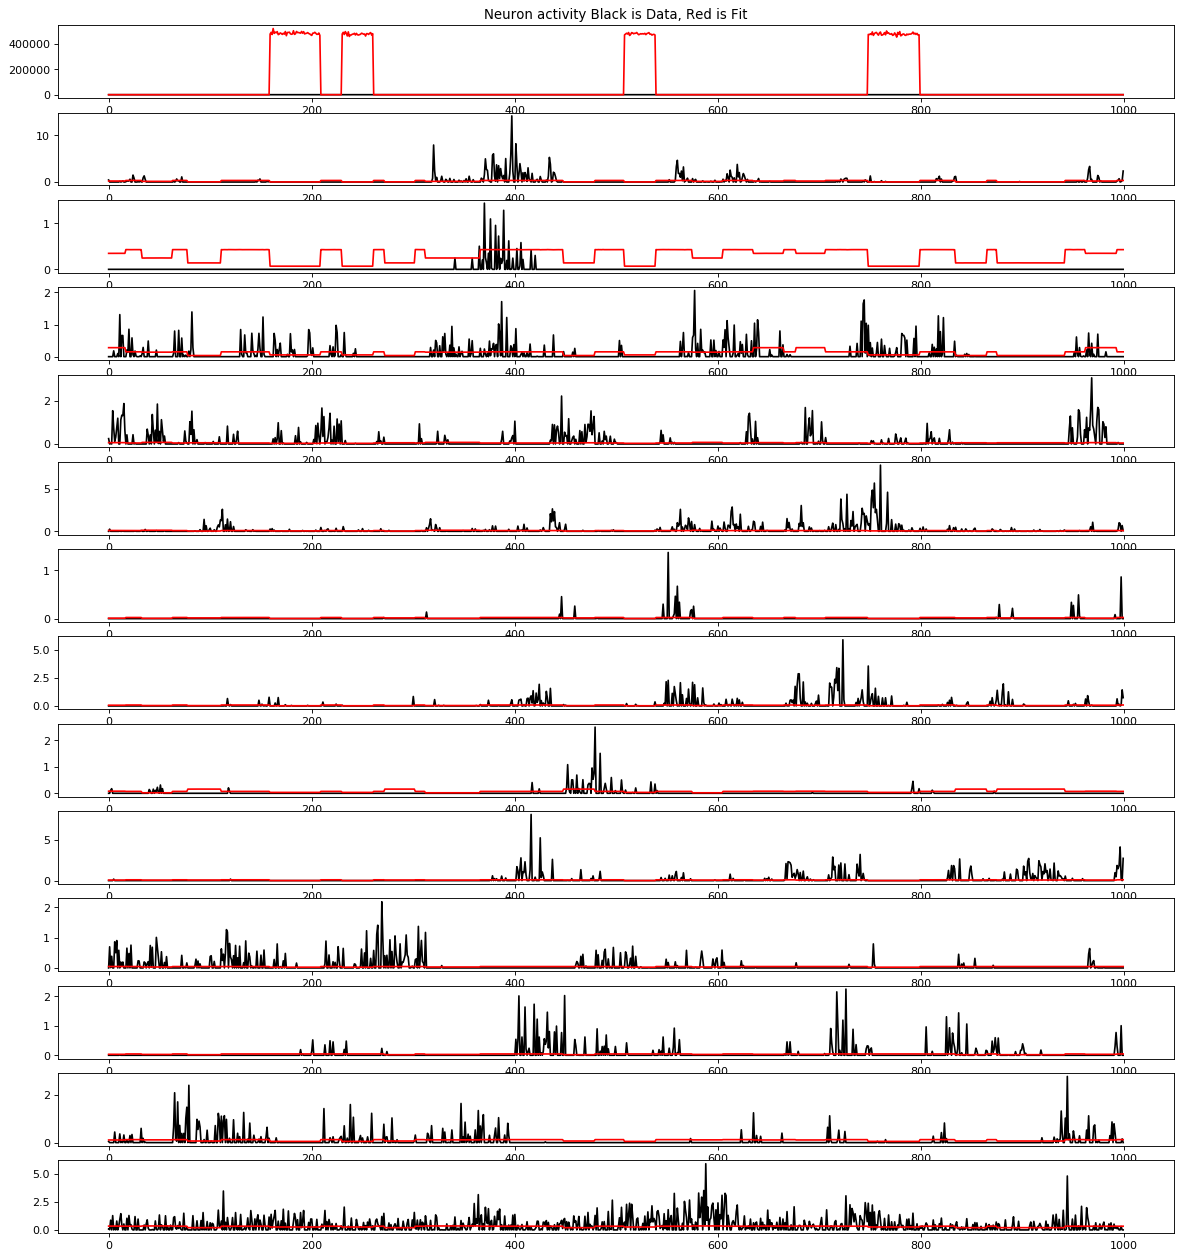

In [8]:
plt.figure(figsize=(18, 20), dpi= 80, facecolor='w', edgecolor='k')
showneurons = 14
plt.subplot(showneurons, 1, 1)
plt.title('Neuron activity Black is Data, Red is Fit')
y_inf = np.array([np.exp(inf['C'][-1] @ mui + inf['d'][-1]) for mui in mu]).reshape(-1, 300)
for i in range(100, 100 + showneurons):
    plt.subplot(showneurons, 1, i-100+1)
    plt.plot(y.reshape(-1, 300)[sl, i], 'k')
    plt.plot(y_inf[sl, i], 'r')
plt.show()

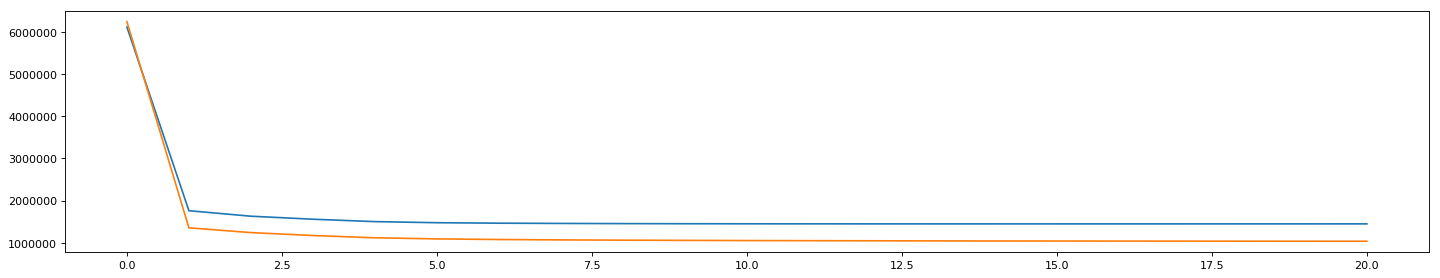

In [70]:
plt.figure(figsize=(22, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(inf['jointloglikelihood'])
plt.plot(inf['logposterior'])
plt.show()

In [73]:
print("A: \n {}".format(inf['A'][-1]))
print("A eigenvals: \n {}".format(np.linalg.eigvals(inf['A'][-1])))

A: 
 [[ 0.78   0.093  0.026  0.01   0.14  -0.062]
 [ 0.103  0.591  0.101  0.28  -0.164  0.071]
 [ 0.061 -0.275  1.075  0.224 -0.105  0.003]
 [ 0.045 -0.156 -0.012  1.087 -0.101  0.14 ]
 [-0.087 -0.007 -0.059  0.05   0.968  0.15 ]
 [ 0.011 -0.117  0.047  0.11  -0.038  0.976]]
A eigenvals: 
 [ 0.739+0.j     0.899+0.035j  0.899-0.035j  0.997+0.j     0.965+0.j
  0.979+0.j   ]
